In [80]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import argparse
import numpy as np

In [81]:
parser = argparse.ArgumentParser(description='')
parser.add_argument('--file', '-f', type=list, help='Input file path')
files = [#'../csvfiles/2024-02-02_LED/20240202204955_pmt_measurements.csv',
         #'../csvfiles/2024-02-02_LED/20240215133119_pmt_measurements_4PMT.csv',
         #'2024-02-12_LED/20240213143256_pmt_measurements.csv',
         #'20240222103243_pmt_measurements.csv',
         #'20240222110429_pmt_measurements.csv',
         #'20240222121131_pmt_measurements.csv',
         #'../../crosscheck/2024-02-22_LED/20240223175129_pmt_measurements.csv',
         #'../csvfiles/2024-02-22_LED/20240223175129_pmt_measurements_with_non_waterproofed.csv',
         #'../../crosscheck/2024-04-05_LED_analysed/20240407191615_pmt_measurements.csv',
         #'../../crosscheck/2024-04-08_analysed/20240409122225_pmt_measurements.csv',
         #'SinglePE_NNVT_23051100_080824_Combined.csv',
         #'SinglePE_BothPMTs_ShortGate_120824_Combined.csv',
         #'SinglePE_BothPMTs_ShortGate_120824_CombinedShort.csv',
         'SinglePE_BothPMTs_LongGate_120824_CombinedShort.csv',
         '../csvfiles/csv_from_alex/from_nnvt_mod3.csv'
         ]
options = ['-f', files]
args = parser.parse_args(args=options)

In [82]:
ylimits = {'gain':[1e5,1e8],
           'chisqr':[None, None],
           'pv_r':[0.,5.],
           'sigma':[0.,30.],
           'pe_res':[0.,150.]
          }
    

key gain
value Gain
key chisqr
value $\chi^2$
key pv_r
value Peak-Valley Ratio
key sigma
value $\sigma$
key pe_res
value PE Resolution %


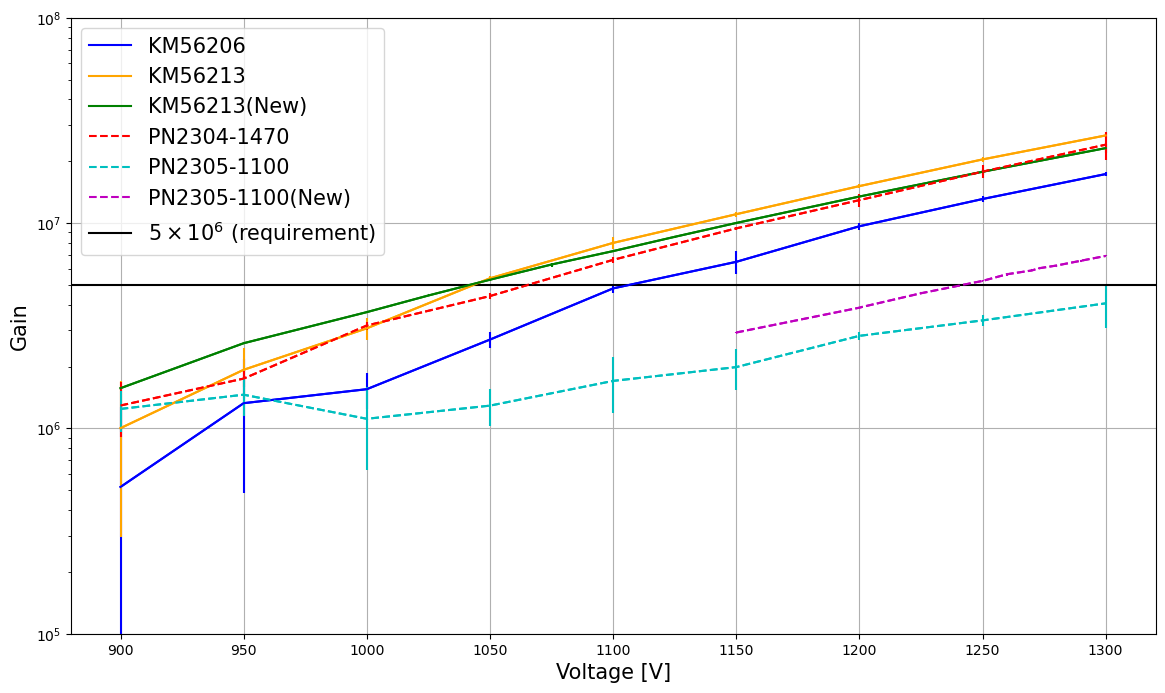

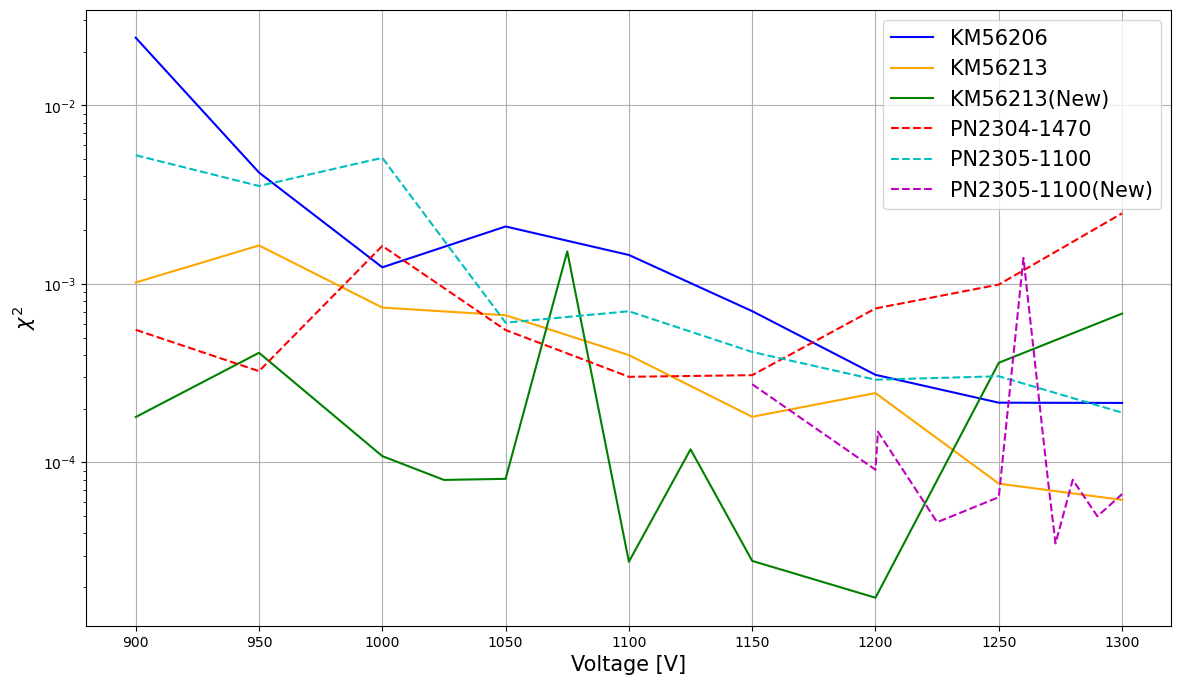

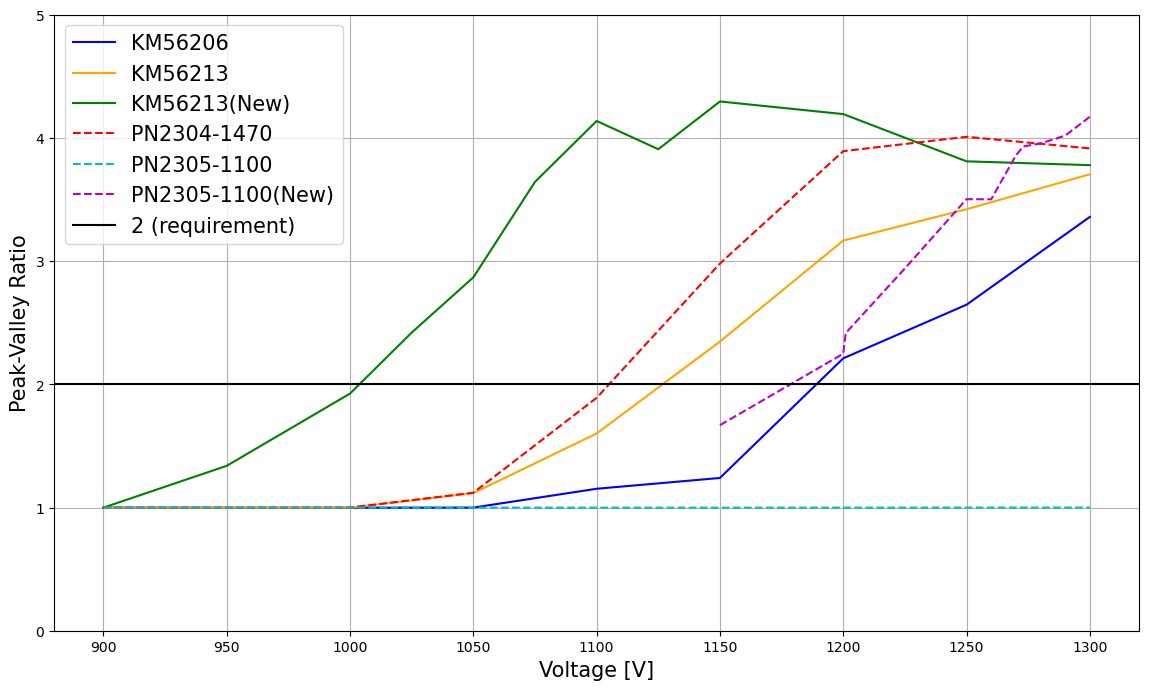

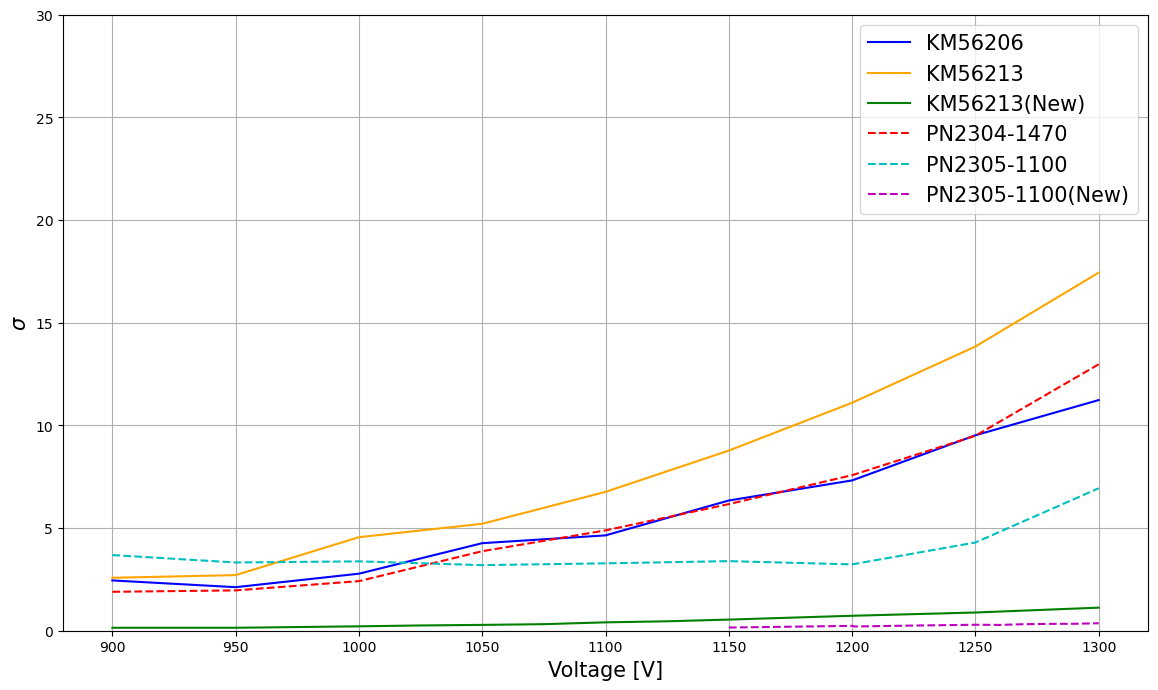

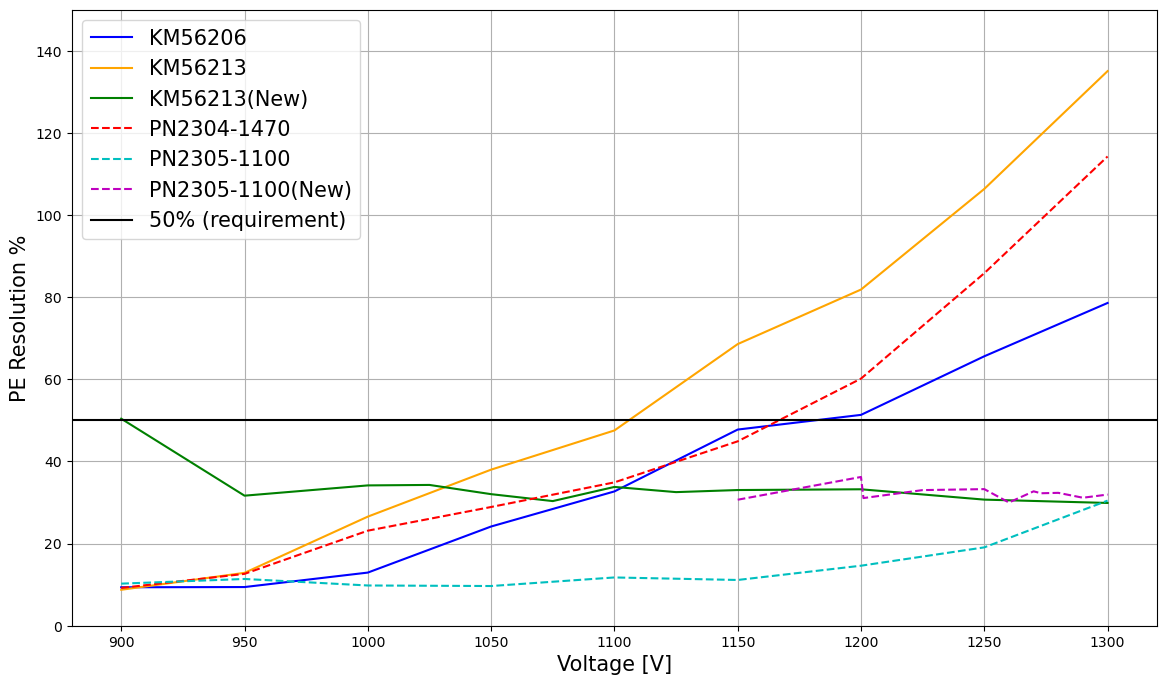

In [83]:

brand_dict = {"ham": "Hamamatsu", "nnvt" : "NNVT", "NNVT":"NNVT", "HAM": "Hamamatsu"}
markers = ['o', 's', 'v', '^']
colors = ("b", "orange", "g", "r", "c", "m", "y", "k")
fname = args.file[0]

fdt = fname.split("_")[0]

df = pd.read_csv(fname)

# Assumes standarde file naming format
def get_v_from_fname(row):
    base = Path(row["fname"]).stem

    # Get brand model and voltage from filename
    brand, model, voltage = base.split("_")
    brand = brand_dict[brand]
    # Get rid of "v" in string if there
    if voltage[-1] == "V" or voltage[-1] == "v":
        voltage = voltage[:-1]
    return brand, model, float(voltage)

# Expand here means when apply returns multiple values, they get assigned to
# each given new column
df[["brand","model","v"]] = df.apply(get_v_from_fname, axis="columns", result_type="expand")

# Sort so V is in order
df = df.sort_values(["v","fname"], ascending=True)
df = df.set_index("v")

# Group by the model and plot each value
df_group = df.groupby("model")


# Get the NNVT measurements if given
if len(args.file) > 1:
    nnvt_fname = args.file[1]
    nnvt_df = pd.read_csv(nnvt_fname)

    # Only get the same models for direct comparison
    nnvt_df = pd.merge(nnvt_df, df["model"].drop_duplicates())
    # Add clarification in label
    nnvt_df["model"] = nnvt_df["model"].apply(lambda x: x + " (NNVT)")
    nnvt_df = nnvt_df.sort_values(["v","model"], ascending=True)
    nnvt_df = nnvt_df.set_index("v")

    # Given in units of 1e7
    nnvt_df["gain"] *= 1e7
    nnvt_df_group = nnvt_df.groupby("model")

plot_cols = {
    "gain" : "Gain", 
    "chisqr" : r"$\chi^2$", 
    "pv_r" : "Peak-Valley Ratio", 
    "sigma" : r"$\sigma$", 
    "pe_res" : "PE Resolution %"
}

# List of values to be log-plotted
logs = [
    'gain',
    "chisqr"
]

# Marker size is a bit small by default
msize = 15

fontsize = 15

for key,value in plot_cols.items():
    print('key', key)
    print('value', value)
    fig, ax = plt.subplots()
    

    
    # Cycle through grouped df plotting each PMT
    idx=0
    for pmt,df_pmt in df_group:
        if type(df_pmt[key].values[0]) != str:
            val =  [float(str_v) for str_v in df_pmt[key].values]
            err = []
        #elif '(' in df_pmt[key].values:
        else:
            val = [ str_v.replace('(', '').replace(')','').split(',')[0] for str_v in df_pmt[key].values ]
            err = [ str_v.replace('(', '').replace(')','').split(',')[1] for str_v in df_pmt[key].values ]
            val = [float(i) for i in val]
            err = [float(i) for i in err]
        
        #print('key',key)
        #print(val)
        #print('max', np.max(val))

        
        if 'KM' in pmt:
            marker = markers[0]
            linestyle = '-'
        elif 'PN' in pmt:
            marker = markers[1]
            linestyle = ':'
            if 'PN23' in pmt:
                marker = markers[2]
                linestyle = '--'
            if '(NNVT)' in pmt:
                marker = markers[3]
                linestyle = ':'
        color=colors[idx]
        format_str = "{color}{marker}-".format(color=color, marker=marker)
        #ax.plot(df_pmt[key], format_str, label=pmt)
        ax.plot(df_pmt.index.values, val, label=pmt, color=color, linestyle=linestyle)
        if len(err)>0:
            if key=='gain':
                ax.errorbar(df_pmt.index.values, xerr=0.25, y=val, yerr = err, color=color, linestyle=linestyle)

        idx+=1

    if len(args.file) > 1:
        try:
            # Same for NNVT df, if it has the info
            #idx = 0
            for pmt,df_pmt in nnvt_df_group:

                if 'KM' in pmt:
                    marker = markers[0]
                    linestyle = '-'
                elif 'PN' in pmt:
                    marker = markers[1]
                    linestyle = ':'
                    if 'PN23' in pmt:
                        marker = markers[2]
                        linestyle = '--'
                    if '(NNVT)' in pmt:
                        marker = markers[3]
                        linestyle = ':'
                color=colors[idx]
                format_str = "{color}{marker}-".format(color=color, marker=marker)
                ax.plot(df_pmt[key], format_str, label=pmt, linestyle=linestyle)
                idx +=1
        except:
            print(f"{key} not in NNVT data. Won't plot")
            
    if key=='gain':
        ax.axhline(5e6, linestyle='-', color='black', label=r'$5\times10^6$ (requirement)')
    if key=='pe_res':
        ax.axhline(50, linestyle='-', color='black', label=r'50% (requirement)')
    if key=='pv_r':
        ax.axhline(2, linestyle='-', color='black', label=r'2 (requirement)')
    


    # Log it if set to
    if key in logs:
        ax.set_yscale("log")

    ax.legend(fontsize=fontsize)
    ax.set_xlabel("Voltage [V]",fontsize=fontsize)
    ax.set_ylabel(value, fontsize=fontsize)
    ax.set_ylim(ylimits[key])
    ax.grid()

    fig.set_size_inches(14,8)

    fig.savefig(f"{fdt}_{key}.png")

plt.show()


### Gain fitting & Get HV at $G=5\times 10^6$ ###

In [84]:
from scipy.optimize import curve_fit

In [85]:
def Func_HV_Gain(x, s, c):
    return s*np.log10(x)+c

In [86]:
pmt_models = df['model'].drop_duplicates().to_list()
gain_tmp=df[ df['model'] == 'PN2305-1100' ]['gain'].values
hv=df[ df['model'] == 'PN2305-1100' ].index.values

In [87]:
gain_kcl = pd.DataFrame()
gain_err_kcl = pd.DataFrame()

PMT Serial: KM56213(New)
[1785906.2319678077, 2831849.104350392, 3916827.3030435247, 4671344.988361637, 5529966.445686949, 6563032.202350154, 7532834.352040272, 8813011.42835349, 10240036.046428869, 13686574.233909132, 18032457.20170664, 23460016.134038508]
best fit parms [  6.92204211 -14.17529014]
HV at Gain=5E+6: 1036 [V]


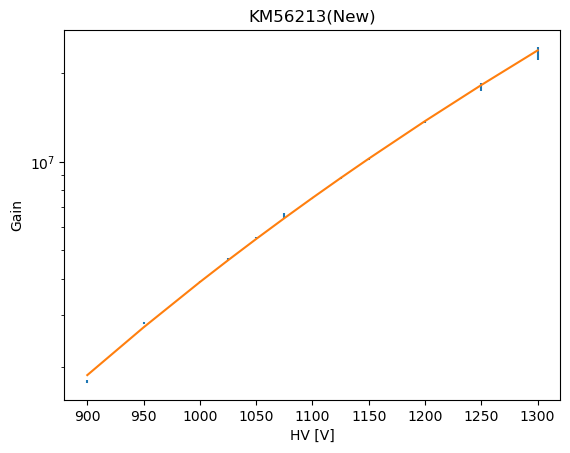

PMT Serial: KM56206
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/tmp/ipykernel_15226/959509632.py:24: RuntimeWarning: divide by zero encountered in log10
  log_gain = np.log10(gain)
/tmp/ipykernel_15226/959509632.py:25: RuntimeWarning: divide by zero encountered in log10
  log_gain_err = np.log10(gain_err)


ValueError: array must not contain infs or NaNs

In [88]:

pmt_serials = df['model'].drop_duplicates().to_list()
for pmt_serial in pmt_serials:
    print('PMT Serial:', pmt_serial)
    #gain_tmp=df[ df['model'] == pmt_serial ]['gain'].values
    gain_tmp=df[ df['model'] == pmt_serial ]['gain_simple'].values
    hv=df[ df['model'] == pmt_serial ].index.values

    ## remove bad points for fitting ##
    #if pmt_serial == 'PN2305-1100':
        #gain_tmp = gain_tmp[3:]
        #hv       = hv[3:]
    #elif pmt_serial == 'KM56206':
    #    gain_tmp = gain_tmp[1:]
    #    hv       = hv[1:]

    gain = []
    gain_err = []
    for i in range(len(gain_tmp)):
        v=gain_tmp[i].replace('(','').replace(')','').replace(' ','').split(',')
        gain.append( float(v[0]) )
        gain_err.append( float(v[1]))

    print(gain)
    log_gain = np.log10(gain)
    log_gain_err = np.log10(gain_err)
    parms, cov = curve_fit(Func_HV_Gain, hv, log_gain, sigma=log_gain_err)
    print('best fit parms', parms)
    best_fit_gain = 10**np.array([ Func_HV_Gain(i, parms[0], parms[1]) for i in hv ])
    HV_gain_5e6 = 10**((np.log10(5e6)-parms[1])/parms[0])
    #HV_gain_5e6 = 10**((np.log10(1e7)-parms[1])/parms[0]) # ch0 trouble
    print('HV at Gain=5E+6: {:d} [V]'.format(int(HV_gain_5e6)))

    plt.title(pmt_serial)
    plt.errorbar(hv, xerr=0.25, y=gain, yerr=gain_err, ls='none')
    plt.plot(hv, best_fit_gain)
    plt.xlabel('HV [V]')
    plt.ylabel('Gain')
    plt.yscale('log')
    plt.show()
    

    #if len(gain)<9:
    #    gain = [None for i in range(9-len(gain))] + gain
    #if len(gain_err)<9:
    #    gain_err = [None for i in range(9-len(gain_err))] + gain_err
    #gain_kcl[pmt_serial] = gain
    #gain_err_kcl[pmt_serial] = gain_err
    
    




In [ ]:
hv=df[ df['model'] == 'PN2305-1100' ].index.values
gain_kcl.index = hv
gain_err_kcl.index = hv

In [ ]:
gain_kcl.to_csv('gain_kcl.csv')
gain_err_kcl.to_csv('gain_error_kcl.csv')

### cross-check ###

In [ ]:
gain_glasgow = pd.read_csv('../csvfiles/cross_check/gain_glasgow.csv')
#gain_ral = pd.read_csv('../csvfiles/cross_check/gain_ral.csv')
gain_ral = pd.read_csv('../csvfiles/cross_check/gain_ral_federico_20240531.csv')
gain_gist = pd.read_csv('../csvfiles/cross_check/gain_gist.csv')


In [ ]:
gain_gist

,HV,PN2308-1025,PN2310-1352
0,1100,0.320938,0.230665
1,1180,0.494454,NaN
2,1200,NaN,0.393610
3,1240,NaN,0.496856
4,1300,0.998363,0.701771
5,1400,1.699631,1.143240


In [ ]:
# Correcting gains 
#gain_glasgow['HV'] -= 30

#for c in gain_glasgow.columns:
#    if c=='HV': continue
#    gain_glasgow[c] *= 3.
    
#gain_glasgow

/tmp/ipykernel_15226/1637525231.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


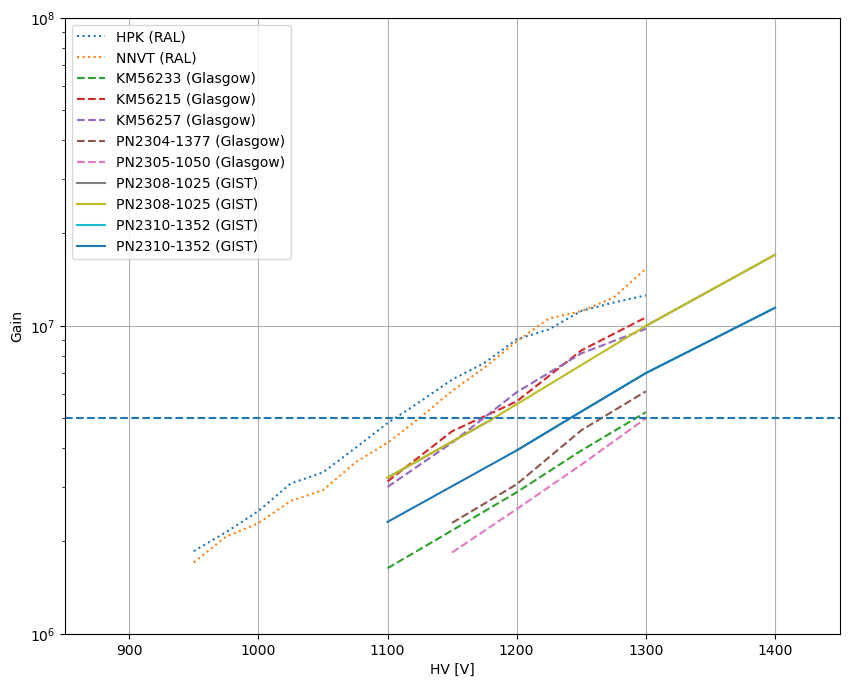

In [ ]:
fig, ax = plt.subplots(1, figsize=[10,8])
# KCL measurements
for pmt in gain_kcl.columns:
    ax.errorbar(x=gain_kcl.index, y=gain_kcl[pmt], yerr=gain_err_kcl[pmt], label = pmt+' (KCL)')
    
# RAL measurements
#ax.errorbar(x=gain_ral['HV'], y=gain_ral['Gain'], yerr=gain_ral['Error'], label = 'HPK (RAL)', linestyle='--')
# from Federico
ax.plot(gain_ral['HV'], gain_ral['Hamamatsu_R14374-31'], label = 'HPK (RAL)', linestyle=':') 
ax.plot(gain_ral['HV'], gain_ral['NNVT_N2031'], label = 'NNVT (RAL)', linestyle=':')

# Glasgow measurements
for pmt in gain_glasgow.columns:
    if pmt == 'HV': continue
    ax.plot(gain_glasgow['HV'], gain_glasgow[pmt], label = pmt+' (Glasgow)', linestyle='--')

# GIST measurements
for pmt in gain_gist.columns:
    if pmt == 'HV': continue
    ax.plot(gain_gist['HV'], gain_gist[pmt]*1e7, label = pmt+' (GIST)')
    ax.plot(gain_gist['HV'][~pd.isna(gain_gist[pmt])], gain_gist[pmt][~pd.isna(gain_gist[pmt])]*1e7, label = pmt+' (GIST)')
    
    

ax.axhline(5e6, linestyle='--')#, label=r'$5\times10^6$')
ax.set_ylabel('Gain')
ax.set_xlabel('HV [V]')
ax.set_yscale('log')
ax.set_xlim([850, 1450])
ax.set_ylim([1e6, 1e8])
ax.grid()
ax.legend()
fig.show()